In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.loader import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from skimage.segmentation import slic, mark_boundaries
from skimage.color import rgb2lab
from skimage.measure import regionprops
from collections import Counter
from tqdm import tqdm
from skimage.color import rgb2lab, rgb2gray

# Thiết lập và cấu hình
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Định nghĩa các lớp
code = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
new_size = 100  # Kích thước ảnh sau resize

Dùng để chuyển số nhãn thành tên lớp (ví dụ: 2 → "glacier").
Duyệt dictionary code ngược lại (giá trị → khóa).

In [2]:
# Hàm tiện ích
def get_name(code_number):
    return list(code.keys())[list(code.values()).index(code_number)]

Đọc ảnh từ thư mục chứa theo nhãn.
Resize ảnh và trả về X (ảnh), y (nhãn).

In [3]:
def load_images(path, folder_name):
    X, y = [], []
    if folder_name != 'seg_pred':
        for folder in os.listdir(os.path.join(path, folder_name)):
            files = gb.glob(os.path.join(path, folder_name, folder, '*.jpg'))
            for file in files:
                image = cv2.imread(file)
                image = cv2.resize(image, (new_size, new_size))
                X.append(image)
                y.append(code[folder])
    else:
        files = gb.glob(os.path.join(path, folder_name, '*.jpg'))
        for file in files:
            image = cv2.imread(file)
            image = cv2.resize(image, (new_size, new_size))
            X.append(image)
    return np.array(X), np.array(y)

# Tải dữ liệu
train_path = './data/intel-image-classification/seg_train/'
test_path = './data/intel-image-classification/seg_test/'

X_train, y_train = load_images(train_path, 'seg_train')
X_test, y_test = load_images(test_path, 'seg_test')

print(f"Training data: {len(X_train)} images")
print(f"Test data: {len(X_test)} images")

Training data: 14034 images
Test data: 3000 images


In [4]:
# Xây đồ thị RAG (Region Adjacency Graph) từ ảnh đã phân đoạn (superpixel).
# Duyệt từng pixel trong segments (output từ slic).
# Nếu pixel (i, j) có superpixel khác với pixel lân cận → thêm cạnh giữa hai superpixel đó.
# Sau đó, tính trung bình màu Lab cho mỗi node và gán làm đặc trưng (node['feature']).
def compute_rag(image, segments):
    graph = nx.Graph()
    lab_image = rgb2lab(image)
    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            current = segments[i, j]
            for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < segments.shape[0] and 0 <= nj < segments.shape[1]:
                    neighbor = segments[ni, nj]
                    if neighbor != current:
                        graph.add_edge(current, neighbor)
    for node in graph.nodes():
        mask = (segments == node)
        mean_color = np.mean(lab_image[mask], axis=0)
        graph.nodes[node]['feature'] = mean_color
    return graph

# Mục đích:

# Tính đặc trưng cho mỗi superpixel.

# Đặc trưng gồm:

# Trung bình màu (mean_color) trong vùng superpixel.
# Eccentricity: độ lệch tâm của vùng.
# Aspect ratio: tỷ lệ chiều rộng/chiều cao.
# Solidity: độ đặc (tỷ lệ diện tích thực / hình bao).
# Centroid: tọa độ tâm khối vùng.
# Perimeter: chu vi.

# Trả về:

# Mảng features với mỗi hàng là đặc trưng của 1 superpixel.

def extract_superpixel_features(image, segments):
    grayscale_image = rgb2gray(image)
    features = []
    props = regionprops(segments, intensity_image=grayscale_image)
    for region in props:
        mask = (segments == region.label)
        mean_color = np.mean(image[mask], axis=0)
        eccentricity = region.eccentricity
        bbox = region.bbox
        aspect_ratio = (bbox[3] - bbox[1]) / (bbox[2] - bbox[0]) if (bbox[2] - bbox[0]) > 0 else 0
        solidity = region.solidity
        centroid = region.centroid
        perimeter = region.perimeter
        features.append([*mean_color, eccentricity, aspect_ratio, solidity, *centroid, perimeter])
    return np.array(features)

# Mục đích:

# Chuyển ảnh sang dạng Data (đồ thị PyTorch Geometric).

# Quy trình:

# Áp dụng SLIC để tạo segments (superpixel).
# Tạo đồ thị RAG từ segments.
# Tính đặc trưng của từng superpixel.
# Map lại các node → đánh chỉ số lại từ 0.
# Tạo edge_index (dạng tensor: [2, num_edges]).
# Trả về Data(x, edge_index).

def image_to_graph(image, n_segments=400):
    segments = slic(image, n_segments=n_segments, compactness=10)
    graph = compute_rag(image, segments)
    features = extract_superpixel_features(image, segments)
    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(graph.nodes())}
    mapped_edges = [(node_mapping[u], node_mapping[v]) for u, v in graph.edges if u in node_mapping and v in node_mapping]
    edge_index = torch.tensor(mapped_edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(features, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

# Mục đích:

# Chuyển toàn bộ ảnh thành graph và lưu xuống file .pt.

# Quy trình:

# Duyệt qua từng cặp (image, label).
# Dùng image_to_graph để tạo Data.
# Gắn nhãn data.y và lưu vào output_dir.

# def save_graphs(images, labels, output_dir):
#     os.makedirs(output_dir, exist_ok=True)
#     for idx, (img, label) in enumerate(tqdm(zip(images, labels), total=len(images), desc=f"Processing {output_dir}")):
#         try:
#             data = image_to_graph(img)
#             data.y = torch.tensor([label], dtype=torch.long)
#             torch.save(data, os.path.join(output_dir, f"graph_{idx}.pt"))
#         except Exception as e:
#             print(f"Lỗi khi xử lý ảnh {idx}: {e}")

def save_graphs(images, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    existing_files = set(os.listdir(output_dir))
    
    for idx, (img, label) in enumerate(tqdm(zip(images, labels), total=len(images), desc=f"Processing {output_dir}")):
        save_path = os.path.join(output_dir, f"graph_{idx}.pt")
        if f"graph_{idx}.pt" in existing_files:
            continue  # Đã tồn tại
        try:
            data = image_to_graph(img)
            data.y = torch.tensor([label], dtype=torch.long)
            torch.save(data, save_path)
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {idx}: {e}")

# === Gọi xử lý ===
save_graphs(X_train, y_train, 'graphs/train_graphs')
save_graphs(X_test, y_test, 'graphs/test_graphs')


Processing graphs/test_graphs: 100%|██████████| 3000/3000 [00:00<00:00, 249700.59it/s]


In [5]:
# Mục đích:

# Đọc các file .pt trong thư mục → load thành danh sách các Data.

def load_graphs_from_folder(folder):
    graphs = []
    files = sorted([f for f in os.listdir(folder) if f.endswith('.pt')])
    
    for file in tqdm(files, desc=f"Loading graphs from {folder}"):
        path = os.path.join(folder, file)
        try:
            data = torch.load(path, weights_only=False)
            graphs.append(data)
        except Exception as e:
            print(f"Lỗi khi load {file}: {e}")
    
    return graphs

train_graphs = load_graphs_from_folder('graphs/train_graphs')
test_graphs = load_graphs_from_folder('graphs/test_graphs')


Loading graphs from graphs/train_graphs:   0%|          | 0/14034 [00:00<?, ?it/s]

Loading graphs from graphs/test_graphs: 100%|██████████| 3000/3000 [00:50<00:00, 59.97it/s]


In [6]:
# GCN với 3 tầng GCNConv, normalization, ReLU, dropout.
# Cuối cùng là hai tầng Linear để phân loại thành 6 lớp.

class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dims[0])
        self.bn1 = BatchNorm(hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        self.bn2 = BatchNorm(hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.bn3 = BatchNorm(hidden_dims[2])
        self.fc1 = Linear(hidden_dims[2], hidden_dims[3])
        self.fc2 = Linear(hidden_dims[3], num_classes)
        self.relu = ReLU()
        self.dropout = Dropout(dropout)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.relu(self.bn3(self.conv3(x, edge_index)))
        x = global_mean_pool(x, batch)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [13]:
import copy

# Theo dõi loss và accuracy
train_losses = []
val_accuracies = []

# DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Khởi tạo mô hình
model = GCNModel(input_dim=9, hidden_dims=[128, 64, 32, 16], num_classes=6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Tạo thư mục lưu mô hình
os.makedirs("model", exist_ok=True)

# Biến theo dõi
best_accuracy = 0.0
patience = 10
epochs_no_improve = 0
max_epochs = 100

# Dùng DataLoader để nạp batch graph.
# Sử dụng Adam optimizer, CrossEntropyLoss.
# Ghi nhận độ chính xác tốt nhất, dùng early stopping sau patience lần không cải thiện.

for epoch in range(max_epochs):
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Đánh giá
    model.eval()
    correct = 0
    y_pred, y_true = [], []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(data.y.view(-1).cpu().numpy())

    accuracy = correct / len(test_graphs)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

    train_losses.append(total_loss)
    val_accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_no_improve = 0
        # Lưu cả model và optimizer
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
            'accuracy': accuracy
        }, "model/gcn_slic.pth")
        print(f"✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: {accuracy:.4f})")
    else:
        epochs_no_improve += 1
        print(f"⚠️ Không cải thiện ({epochs_no_improve}/{patience})")
        if epochs_no_improve >= patience:
            print("🛑 Dừng huấn luyện do không cải thiện sau nhiều lần liên tiếp.")
            break

Epoch 1, Loss: 599.3905, Accuracy: 0.5893
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.5893)
Epoch 2, Loss: 489.1094, Accuracy: 0.6353
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.6353)
Epoch 3, Loss: 456.6426, Accuracy: 0.5927
⚠️ Không cải thiện (1/10)
Epoch 4, Loss: 434.7814, Accuracy: 0.6867
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.6867)
Epoch 5, Loss: 414.7606, Accuracy: 0.6353
⚠️ Không cải thiện (1/10)
Epoch 6, Loss: 408.0729, Accuracy: 0.6723
⚠️ Không cải thiện (2/10)
Epoch 7, Loss: 397.5447, Accuracy: 0.5847
⚠️ Không cải thiện (3/10)
Epoch 8, Loss: 392.8587, Accuracy: 0.6410
⚠️ Không cải thiện (4/10)
Epoch 9, Loss: 388.5343, Accuracy: 0.6030
⚠️ Không cải thiện (5/10)
Epoch 10, Loss: 384.3855, Accuracy: 0.4720
⚠️ Không cải thiện (6/10)
Epoch 11, Loss: 382.8314, Accuracy: 0.7150
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.7150)
Epoch 12, Loss: 375.7014, Accuracy: 0.6453
⚠️ Khôn

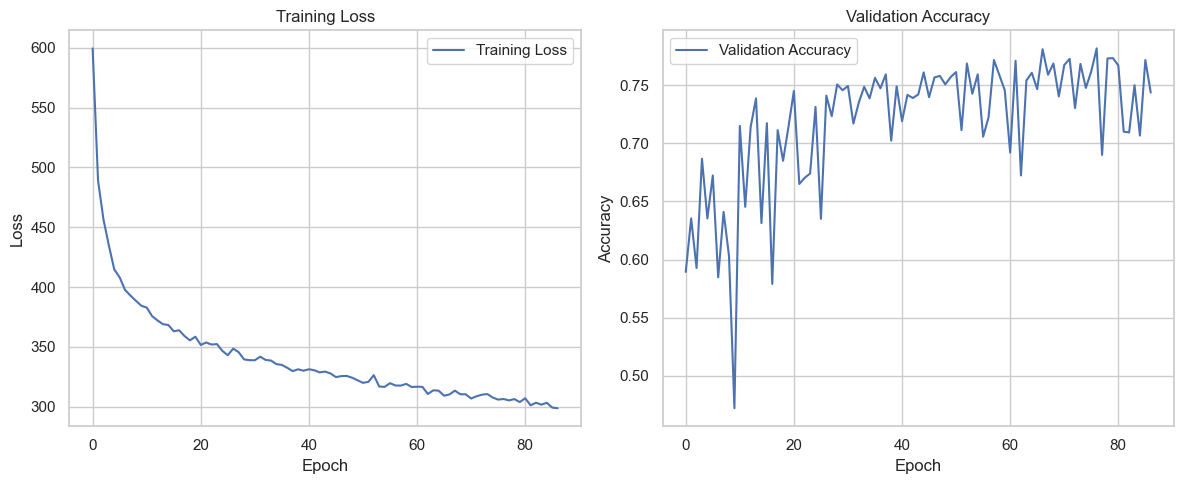

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

   buildings       0.85      0.47      0.60       437
      forest       0.88      0.93      0.91       474
     glacier       0.70      0.77      0.73       553
    mountain       0.62      0.78      0.69       525
         sea       0.74      0.69      0.71       510
      street       0.78      0.79      0.79       501

    accuracy                           0.74      3000
   macro avg       0.76      0.74      0.74      3000
weighted avg       0.76      0.74      0.74      3000



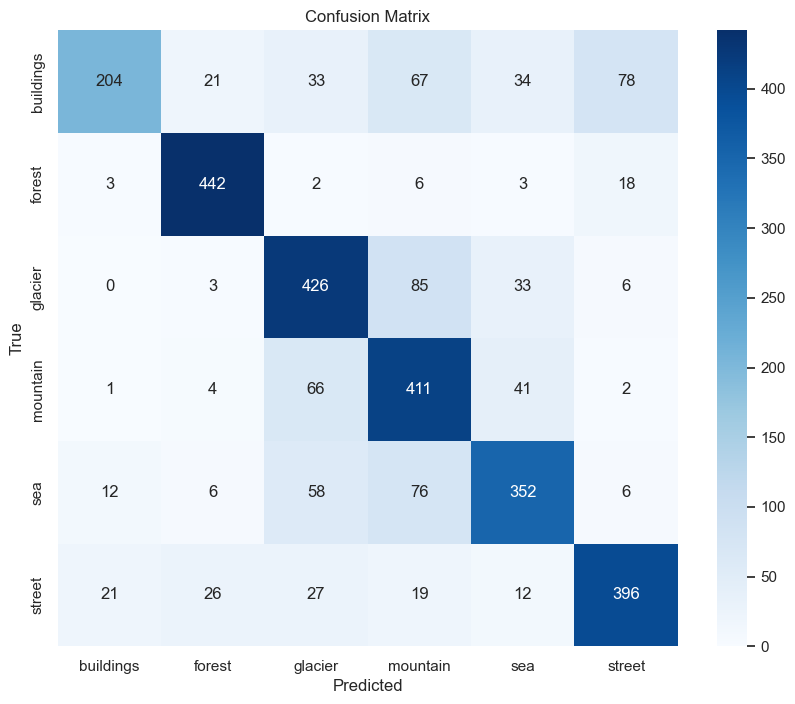

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Dùng danh sách nhãn từ 0 đến 5
labels = list(code.values())
target_names = list(code.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

## ✅ **Lớp được mô hình phân loại tốt**

| **Lớp**      | **Số mẫu đúng** | **Nhận xét**                                                        |
| ------------ | --------------- | ------------------------------------------------------------------- |
| **forest**   | 442             | Phân loại gần như tuyệt đối, chỉ rất ít nhầm với các lớp khác.      |
| **glacier**  | 426             | Mức chính xác rất cao, chỉ nhầm nhỏ với `mountain`.                 |
| **mountain** | 411             | Hiệu suất tốt, tuy còn nhầm một phần nhỏ với `glacier`.             |
| **street**   | 396             | Nhận diện hiệu quả, chỉ có nhầm nhẹ với các lớp khác.               |
| **sea**      | 352             | Kết quả tốt, dù vẫn còn nhầm với `glacier` (58) và `mountain` (76). |

---

## ⚠️ **Lớp phân loại chưa thực sự tốt**

| **Lớp**       | **Số mẫu đúng** | **Nhận xét**                                                                       |
| ------------- | --------------- | ---------------------------------------------------------------------------------- |
| **buildings** | 204             | Hiệu suất còn thấp hơn so với các lớp khác; nhầm đáng kể với `street`, `mountain`. |

---

## 🔄 **Các nhầm lẫn nổi bật**

| **Từ lớp → Đến lớp**     | **Số lượng nhầm** | **Nhận xét**                                                            |
| ------------------------ | ----------------- | ----------------------------------------------------------------------- |
| `glacier` → `mountain`   | 85                | Nhầm phổ biến do đặc điểm hình ảnh tương tự (tuyết, núi đá).            |
| `sea` → `mountain`       | 76                | Có thể do hình ảnh vùng biển giáp núi hoặc sai lệch đặc trưng hình học. |
| `buildings` → `mountain` | 67                | Cảnh có công trình gần núi có thể gây nhầm lẫn.                         |
| `buildings` → `street`   | 78                | Tiếp tục là nhầm lẫn phổ biến giữa 2 lớp đô thị.                        |

---

## 📊 **Tổng quan**

Mô hình trong confusion matrix này có **hiệu suất tổng thể rất tốt**, thể hiện qua số lượng phân loại đúng cao ở hầu hết các lớp:

* **Cải thiện rõ rệt** ở các lớp như `glacier`, `forest`, và `mountain`.
* **Lỗi nhầm giảm mạnh** so với các biểu đồ trước đó, đặc biệt là giảm nhầm giữa `glacier` ↔ `sea`, `sea` ↔ `buildings`.
* **Vấn đề chính còn lại là lớp `buildings`**, vẫn bị nhầm nhiều với `street` và `mountain`.

---

In [ ]:
def predict_sample(image, n_segments=400):
    segments = slic(image, n_segments=n_segments, compactness=10)
    graph = compute_rag(image, segments)
    features = extract_superpixel_features(image, segments)
    
    data = image_to_graph(image, n_segments=n_segments)
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
    data = data.to(device)

    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax().item()
    
    # Vẽ hình gốc
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Superpixel boundaries
    plt.subplot(1, 3, 2)
    marked = mark_boundaries(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), segments)
    plt.imshow(marked)
    plt.title("SLIC Superpixels")
    plt.axis('off')

    # Đồ thị RAG
    plt.subplot(1, 3, 3)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_size=50, with_labels=False)
    plt.title("Region Adjacency Graph")

    plt.suptitle(f"Predicted: {get_name(pred)}", fontsize=14)
    plt.tight_layout()
    plt.show()


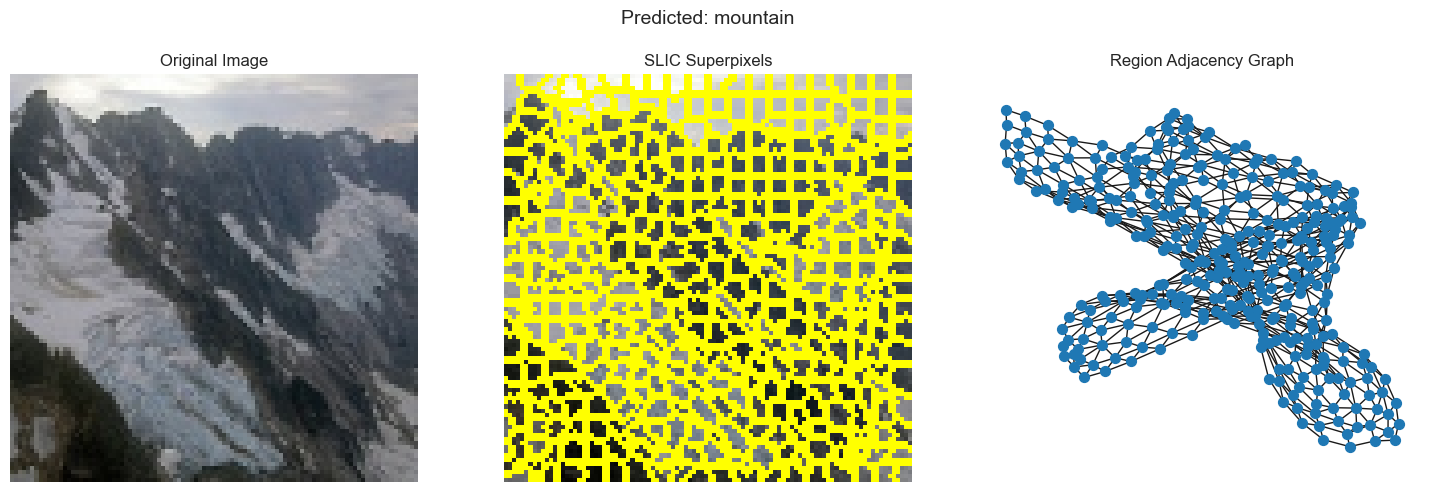

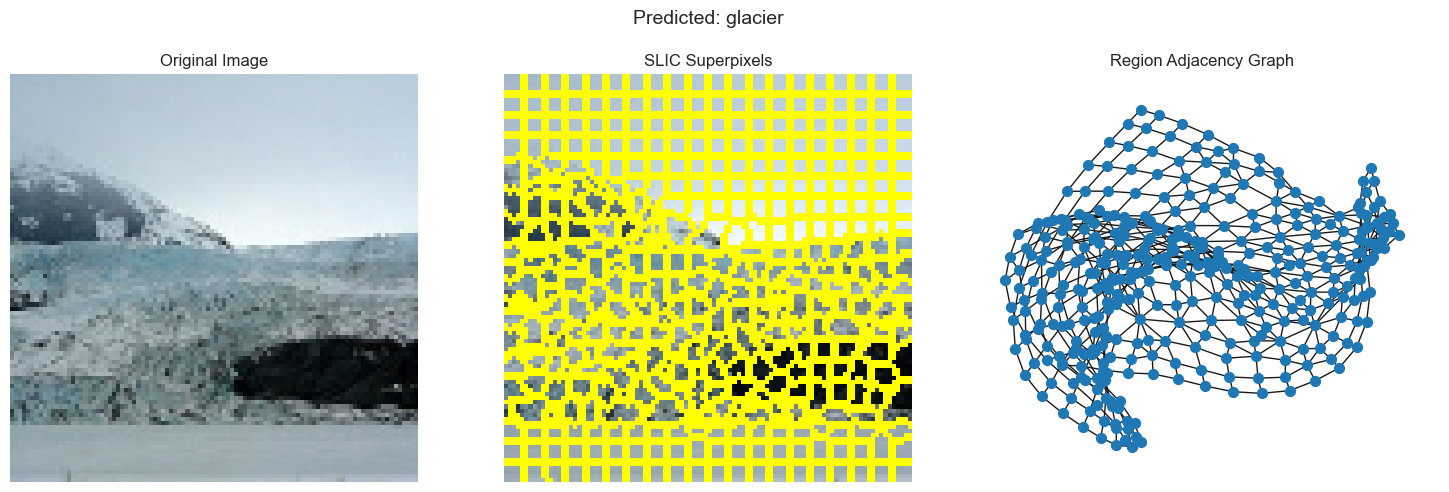

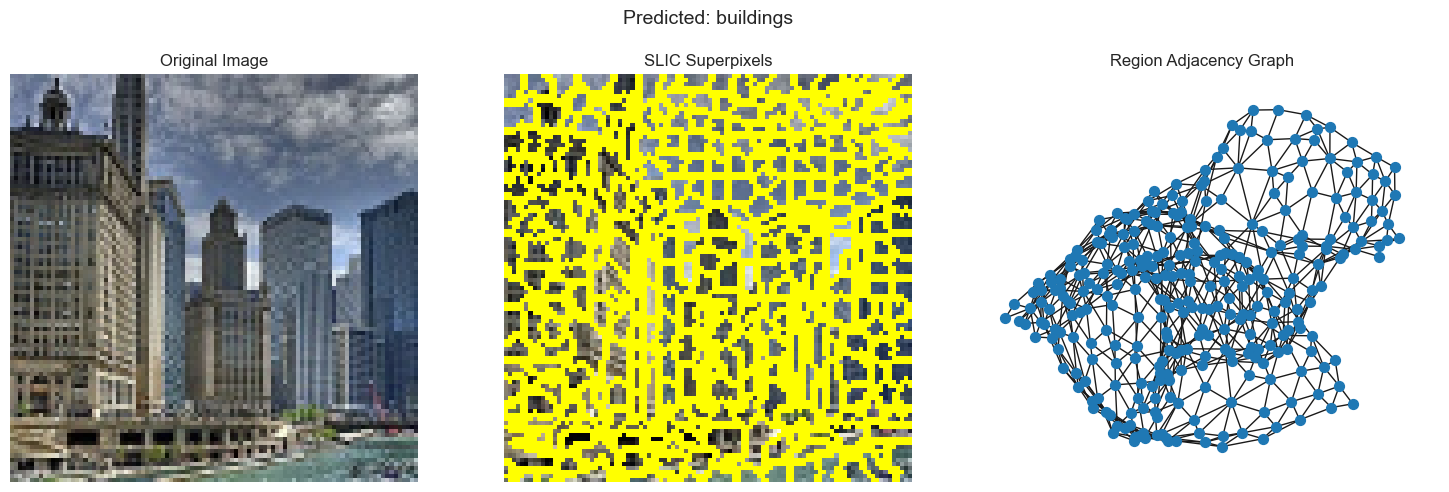

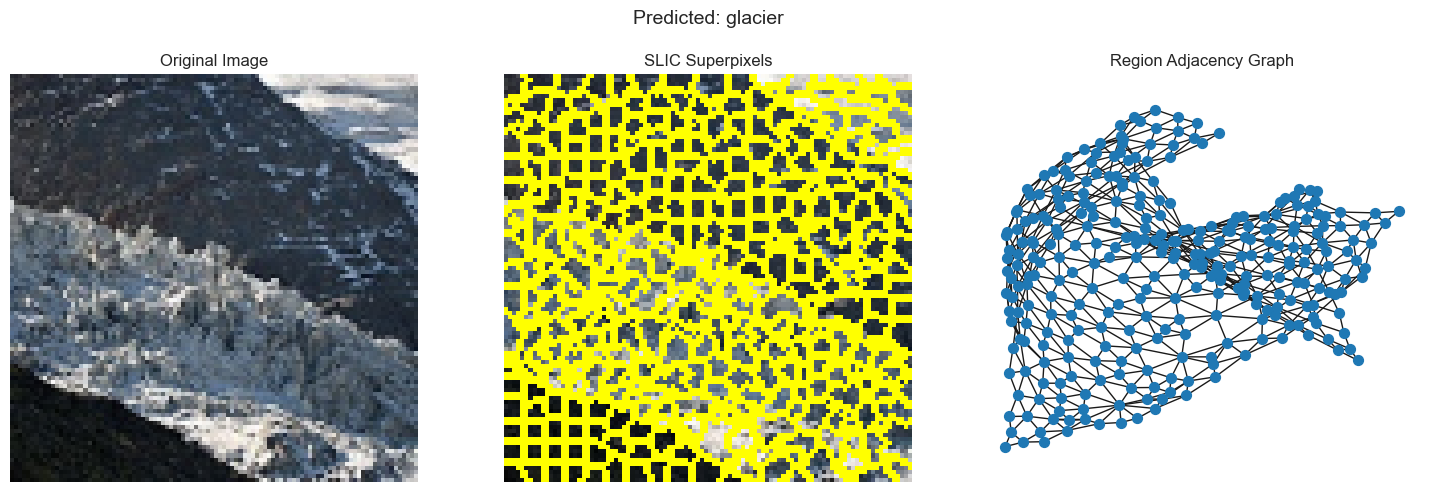

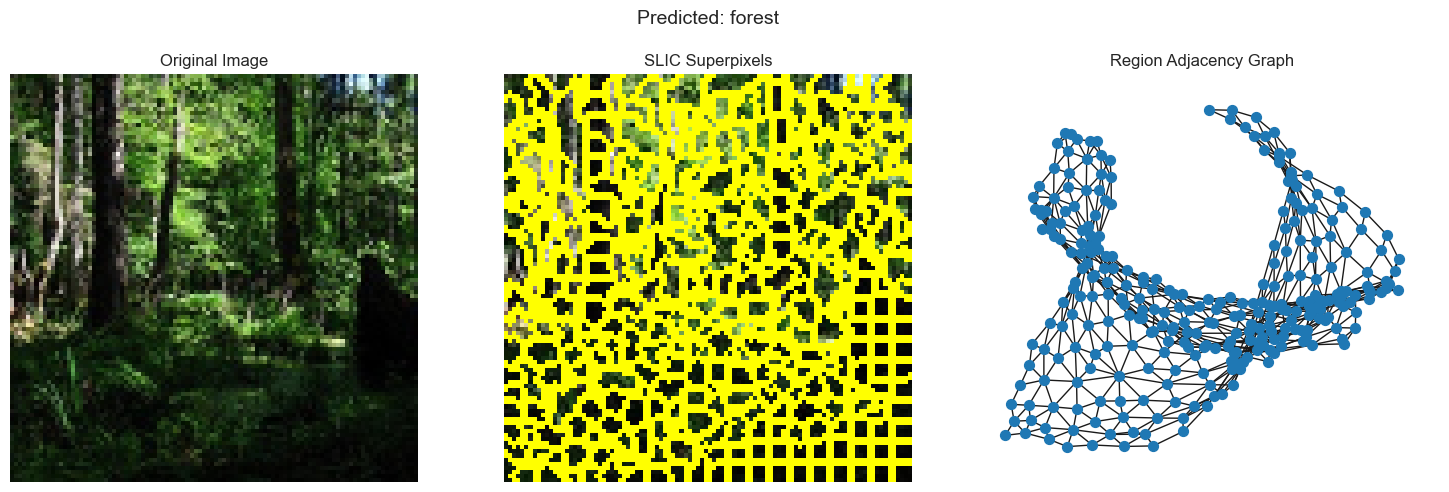

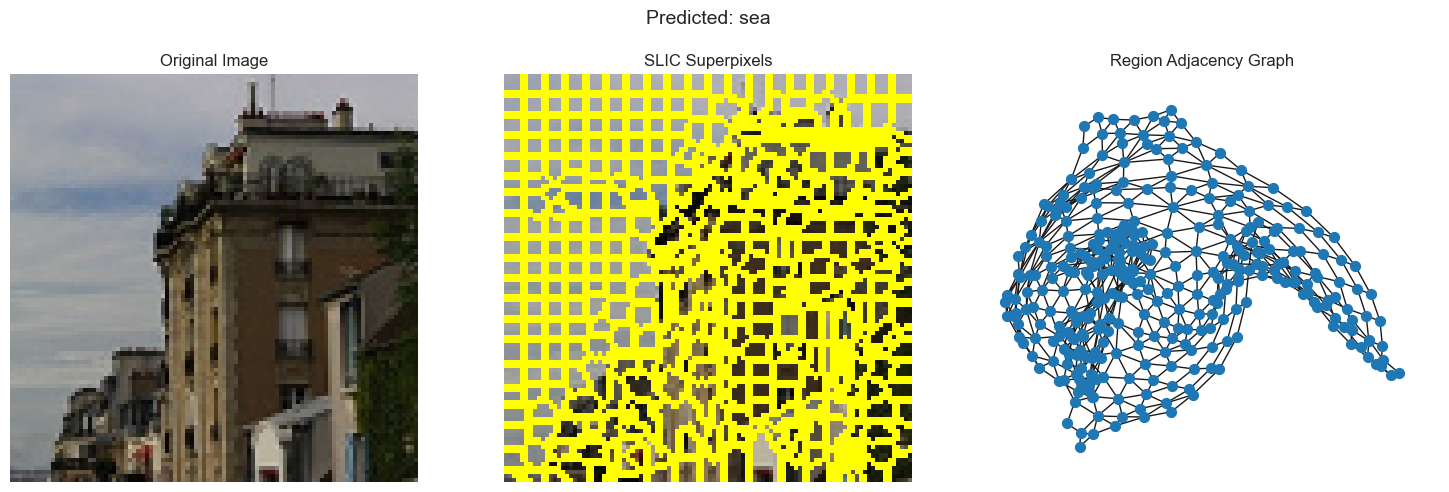

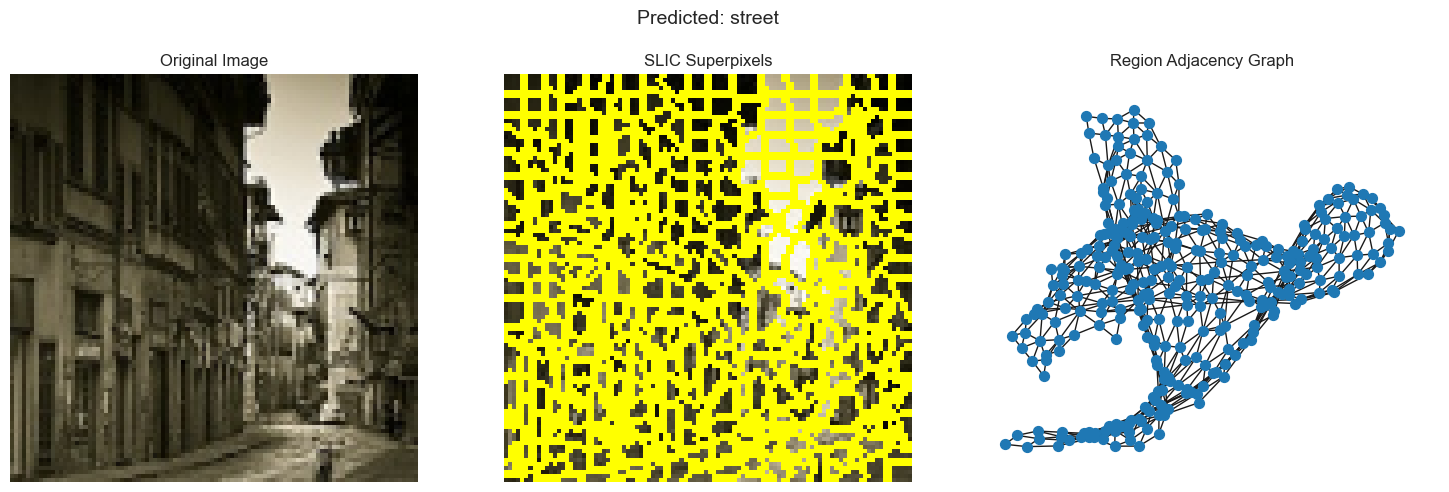

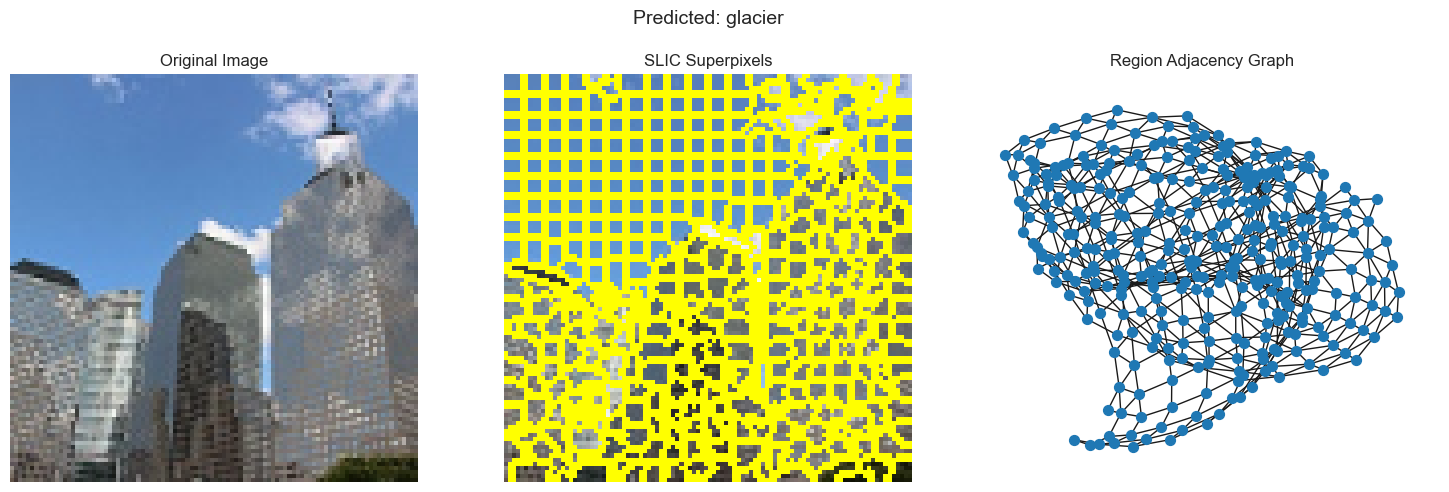

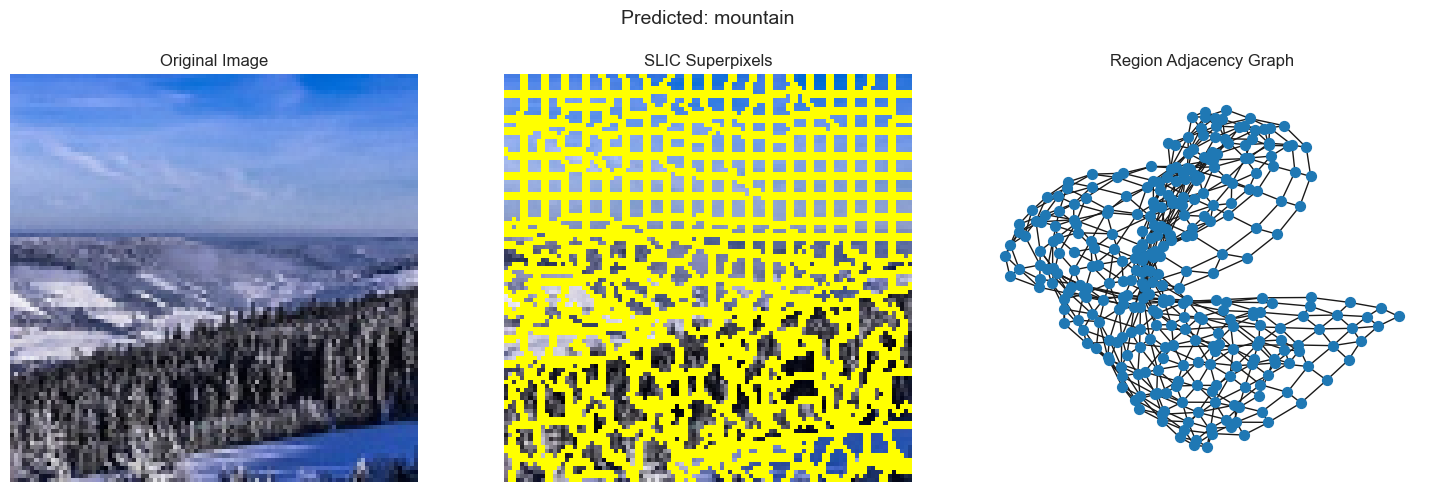

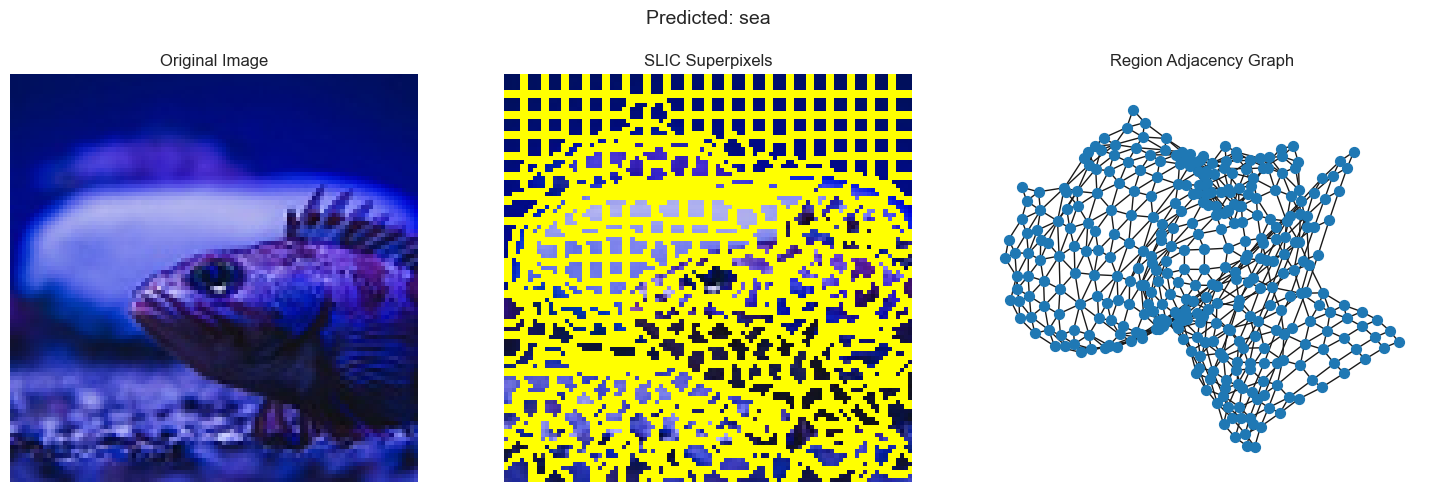

In [25]:
for i in np.random.randint(0, len(X_test), 10):
    predict_sample(X_test[i])